In [31]:
import warnings
warnings.filterwarnings("ignore")
import matplotlib.gridspec as gridspec
from matplotlib import pyplot as plt
import pickle
import os
import shutil
import pandas as pd
import numpy as np
import networkx as nx
import torch
import sys
from scipy import interpolate, signal, linalg, spatial
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.manifold import SpectralEmbedding
from sklearn.mixture import GaussianMixture
from collections import defaultdict, Counter
from itertools import combinations, product
from multiprocessing import cpu_count
from joblib import Parallel, delayed, pool
from IPython.display import clear_output, HTML
from IPython.core.debugger import set_trace
from tqdm import tqdm_notebook

from graph_metrics import laplacian_keigv_similarity, l2_distance
from utils import place_field_correlation, calc_spike_similarity_cuda, coords2phi, plot_coords_on_circle

N_CPU = cpu_count()
TOY_DATASET = False 

# Notes

Frame rate is ~21 FPS. 
It takes ~10 min to learn. 
It is ~12600 frames. 
To capture learning our timeframe should be several times shorter than 10 min. 
1k frames for time-window. 
Kernel size should represent Hebbian rule temporal, somehow, so there is no need to make it large!

***Idea:
Check intrinsic dimension once again, reduce dimensionality, consider connectivity matrix in reduced space?***


# Create data

In [32]:
track = 'Circle'
mouse = 22
day = 1 
trim0=1500
trim1=100
root = 'data'

# def load_dataset(root, mouse=22, day=1, track='Circle', trim0=1500, trim1=100):

#     '''
#     Loading dataset of cells activity for 
#     mouse: int [22,23,24]
#     day: [1,2,3]
#     track: ['Circle', 'Holy']
#     trim0: trim values from the beginning
#     trim1: trim values from the end
#     '''

calcium_df = pd.read_csv(os.path.join(root,f"{track}/data/CA1_{mouse}_{day}D_initial_data.csv"), 
                         index_col=0)
spikes_df = pd.read_csv(os.path.join(root,f"{track}/spikes/CA1_{mouse}_{day}D_initial_data_spikes.csv"), 
                        index_col=0)
rears_events = pd.read_csv(os.path.join(root,f'CA1_22-25_rears/CA1_{mouse}_{day}D_rears_from_npz.csv'), 
                           index_col=0)

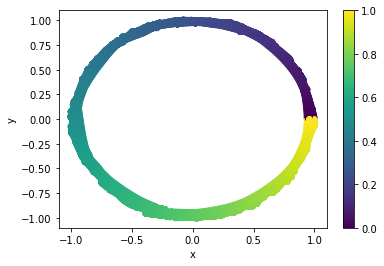

In [49]:
cadata = calcium_df.iloc[:,7:][trim0:-trim1].T.values # [n_neurons, T] 
spdata = spikes_df.iloc[:,1:][trim0:-trim1].T.values # [n_neurons, T]
time = calcium_df['time_s'][trim0:-trim1].values # 21 FPS
rears_events = rears_events[trim0:-trim1]

rear_times = rears_events['time_s'].values
rears_indicators = rears_events['rear_1_outward_-1_inward'].values

cells_with_spikes = np.sum(spdata, axis = 1) > 1.

spdata = spdata[cells_with_spikes]
cadata = cadata[cells_with_spikes]
spdata_bool = spdata.astype(bool)
cadata_ = StandardScaler().fit_transform(cadata.T).T

N, T = spdata.shape
neurons = np.arange(N)

###########
# TARGETS #
###########
coords = calcium_df[['x','y']][trim0:-trim1].values
coords -= coords.mean(0)[None,:]
minmax_scaler = MinMaxScaler((-1,1))
coords_ = minmax_scaler.fit_transform(coords)
coords_normalized = coords_ / np.linalg.norm(coords_, axis=1)[:,None]

phi = np.arctan2(coords_[:,1], coords_[:,0])
phi[phi < 0] = 2*np.pi + phi[phi < 0]

# speed sign
dphi = np.diff(phi, prepend=phi[0])
jump_mask = np.abs(dphi) > 6 # jump through breakpoint
dphi[jump_mask] = -1 * np.sign(dphi[jump_mask]) * np.abs(dphi[jump_mask] - 2*np.pi)
circle_sign = np.sign(dphi)

# speed
shift = np.diff(coords_, prepend=[coords_[0]], axis=0)
speed = np.sqrt((shift**2).sum(1)) * circle_sign
speed_ = MinMaxScaler((-1,1)).fit_transform(speed[:,None]).flatten()

# acceleration
acceleration = np.diff(speed, prepend=speed[0])
acceleration_ = MinMaxScaler((0,1)).fit_transform(acceleration[:,None]).flatten()

# rears indicators
rears_indicators_abs = np.pad(np.abs(rears_indicators), pad_width=(T - rears_indicators.shape[0])//2)
phi_ = MinMaxScaler().fit_transform(phi[:,None]).flatten()

targets = {
    'x': coords_[:,0],
    'y': coords_[:,1],
    'v': speed_,
    'a': acceleration_,
    'phi': phi_
}

# return targets

plt.scatter(targets['x'], targets['y'], c=phi_)
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar()
plt.show()

# Create toy dataset

In [63]:
# TOY_DATASET = True

# toy_steps_per_round = 1000
# dphi = 2*np.pi/toy_steps_per_round
# toy_neurons_per_place = 10
# toy_n_places = 4
# toy_timesteps = 5000
# toy_spdata = np.zeros((toy_n_places*toy_neurons_per_place, toy_timesteps))
# toy_phi = []

# for i in range(toy_timesteps):
#     j = i%(toy_steps_per_round) # index within round 
#     step = dphi*j
#     toy_phi.append(step)
#     # number of place
#     k = int(j//(toy_steps_per_round//toy_n_places))
    
#     if i%25==0 and j%(toy_steps_per_round//toy_n_places) != 0:
#         for m,random_offset in enumerate(np.random.choice(np.arange(-3,4), size=toy_neurons_per_place)):
#             toy_spdata[min(toy_neurons_per_place*toy_n_places - 1, (k*toy_neurons_per_place)+m),
#                        i+random_offset] = 1.
    
# toy_phi = np.array(toy_phi) #- np.pi
# x_toy = np.cos(toy_phi)
# y_toy = np.sin(toy_phi)

# plt.figure()
# plt.scatter(x_toy, y_toy, c=toy_phi)
# plt.show()

# Set hyperparameters 

In [68]:
dt = 1000
kernel_size=49
start,end = 0, T-dt
SYGMA = 5
kernel_type = 'gaussian'
# T_RISE = 10
# T_OFF = 40
bins=25

REMAKE_CORR = False
REMAKE_PF = False
SELECT_NEURONS = False

if SELECT_NEURONS:
    neurons_selected = selective_cells
else:
    neurons_selected = neurons

In [69]:
if kernel_type == 'gaussian':
    assert kernel_size%2==1
    if SYGMA is None:
        SYGMA = kernel_size//7
    sp = signal.gaussian(M=kernel_size, std=SYGMA)

elif kernel_type == 'exponential':
    def spike_form(t):
        return (1-np.exp(-t/T_RISE))*np.exp(-t/T_OFF)
    x = np.linspace(0, kernel_size, num = kernel_size)
    sp = spike_form(x)[::-1].copy()

sp_torch = torch.tensor(sp).float().cuda()
sp_torch_batch = sp_torch.unsqueeze(0).unsqueeze(0)
spdata_torch = torch.tensor(spdata).float().cuda()

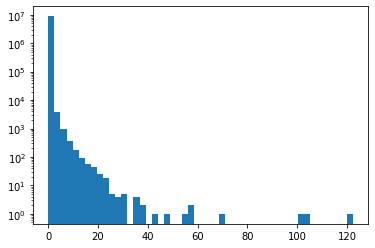

In [70]:
plt.hist(spdata.flatten(), bins=50)
plt.yscale('log')
plt.show()

In [71]:
result_torch = torch.conv1d(input=spdata_torch.unsqueeze(1), weight=sp_torch_batch, padding=kernel_size//2).squeeze(1)#[:,:dt]
# vis = []
# for i in range(20):
#     vis.append(result_torch[neurons_selected, dt*i:dt*(i+1)].detach().cpu().numpy())
#     vis.append(np.ones((1,dt))*10)
# vis = np.vstack(vis)
# plt.figure(figsize=(50,20), dpi=200)
# plt.imshow(vis)
# plt.show()

In [81]:
spdata_convolved = result_torch.detach().cpu().numpy()
spdata_convolved_ = spdata_convolved/spdata_convolved.max() #MinMaxScaler().fit_transform(spdata_convolved.T).T

In [82]:
spdata_convolved.shape

(522, 17175)

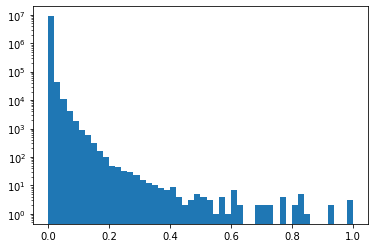

In [84]:
plt.hist(spdata_convolved_.flatten(), bins=50)
plt.yscale('log')
plt.show()

# Create place-field and convolved spike correlation maps

In [183]:
name = 'TOY' if TOY_DATASET else f'Circle_M{mouse}_D{day}'

if kernel_type == 'exponential':
    corr_dir = f'./experimental_data/corrmap_data/corrmaps_' + name +  f'_dt{dt}_kernel{kernel_size}_{kernel_type}_TRISE{T_RISE}_TOFF{T_OFF}'  + \
            (f'_selected_A{ACTIVITY_SELECTIVE_THRESHOLD}_S{STD_SELECTIVE_THRESHOLD}' if SELECT_NEURONS else '')
    
elif kernel_type == 'gaussian':
    corr_dir = f'./experimental_data/corrmap_data/corrmaps_' + name + f'_dt{dt}_kernel{kernel_size}_{kernel_type}_SYGMA{SYGMA}'  + \
            (f'_selected_A{ACTIVITY_SELECTIVE_THRESHOLD}_S{STD_SELECTIVE_THRESHOLD}' if SELECT_NEURONS else '')

if os.path.exists(corr_dir):
        if REMAKE_CORR:
            print('Removing corr_dir?')
            answer = input()
            if answer == 'yes':
                shutil.rmtree(corr_dir)
                os.makedirs(corr_dir, exist_ok=True)
else:
    os.makedirs(corr_dir)
    
    
pf_dir = f'./experimental_data/pf_data/pf_' + name + f'_dt{dt}_hist2d-bins{bins}' + \
            (f'_selected_A{ACTIVITY_SELECTIVE_THRESHOLD}_S{STD_SELECTIVE_THRESHOLD}' if SELECT_NEURONS else '')

if os.path.exists(pf_dir):
        if REMAKE_PF:
            print('Removing pf_dir?')
            answer = input()
            if answer == 'yes':
                shutil.rmtree(pf_dir)
                os.makedirs(pf_dir, exist_ok=True)
else:
    os.makedirs(pf_dir)

# Making matrices

In [194]:
if REMAKE_CORR:
    sim_matrices = Parallel(n_jobs=10, verbose=1)(delayed(calc_spike_similarity_cuda)(sp_torch_batch,
                                                                                     spdata_torch[neurons_selected,i:i+dt], 
                                                                                     save=True,
                                                                                     corr_dir=corr_dir,
                                                                                     i=i) for i in tqdm_notebook(range(start,end)))
    clear_output()

In [195]:
if REMAKE_PF:
    pf_paths = Parallel(n_jobs=-1, verbose=1)(delayed(place_field_correlation)(spdata_bool[neurons_selected,i:i+dt], 
                                                                              coords_[i:i+dt,:],
                                                                              save=True,
                                                                              pf_dir=pf_dir,
                                                                              i=i,
                                                                              bins=bins) for i in tqdm_notebook(range(start,end)))
    clear_output()

In [196]:
corr_paths = np.array([os.path.join(corr_dir, path) for path in sorted(os.listdir(corr_dir), key=lambda x: int(x.split('.')[0]))])
pf_paths = np.array([os.path.join(pf_dir, path) for path in sorted(os.listdir(pf_dir), key=lambda x: int(x.split('.')[0]))])

In [197]:
pf_dir, corr_dir, len(neurons_selected)

('./experimental_data/pf_data/pf_Circle_M25_D1_dt1000_hist2d-bins25',
 './experimental_data/corrmap_data/corrmaps_Circle_M25_D1_dt1000_kernel49_gaussian_SYGMA5',
 197)

In [198]:
assert len(corr_paths) == len(pf_paths) and len(corr_paths) > 0

# Compare

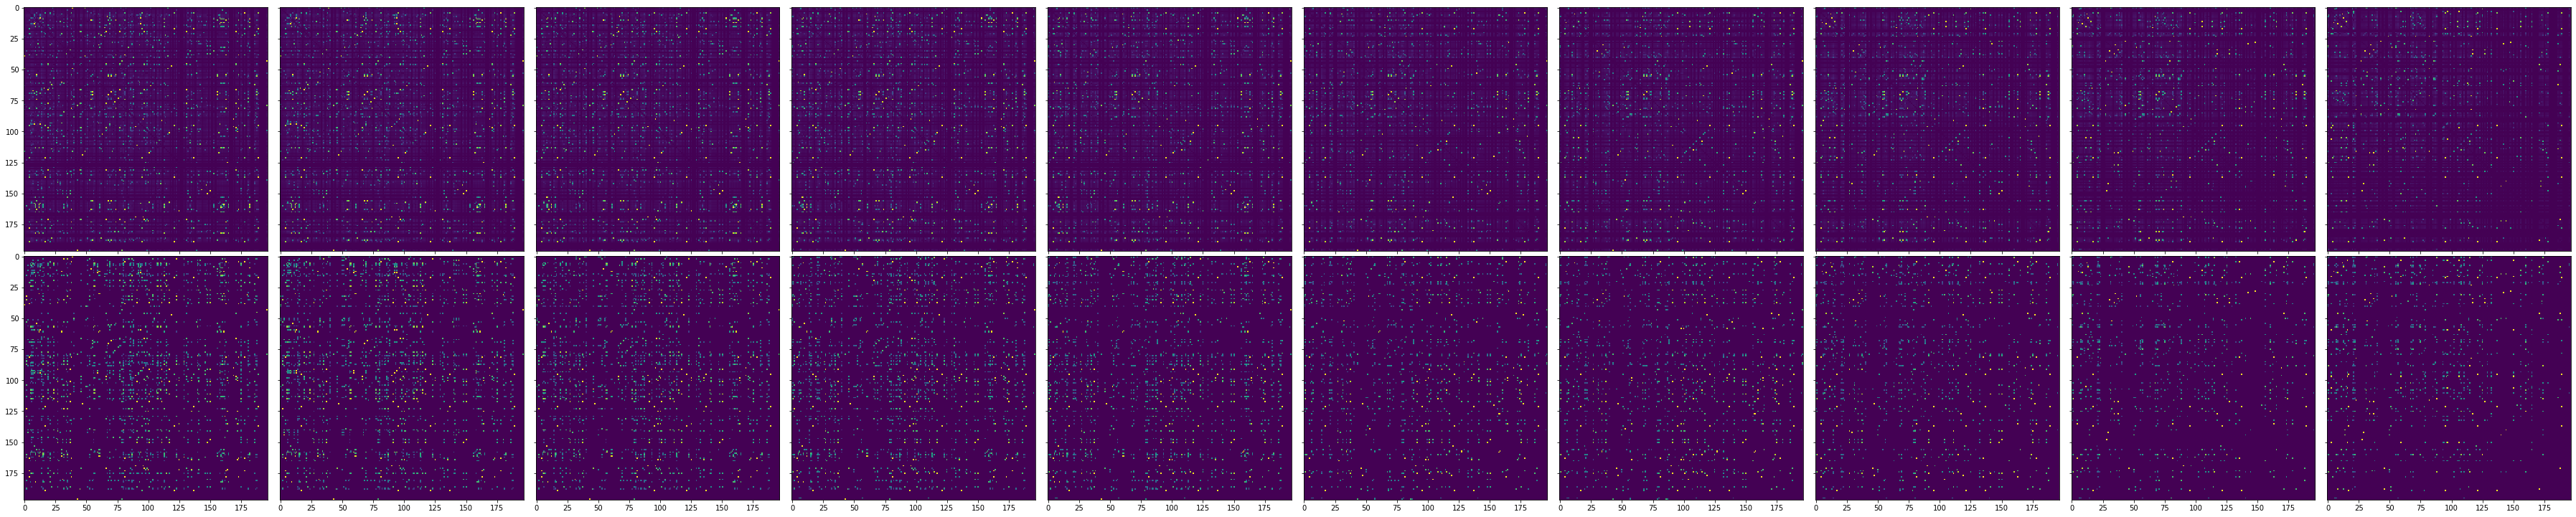

In [201]:
n_vis= 10
dil_vis = 100
fig, axes = plt.subplots(ncols=n_vis, nrows=2, figsize=(5*n_vis,10), sharex=True, sharey=True)
for i,p1,p2 in zip(range(n_vis), corr_paths[::dil_vis][:n_vis], pf_paths[::dil_vis][:n_vis]):
    s = np.load(p1)
    p = np.load(p2) # [neurons_selected][:,neurons_selected]
    axes[0,i].imshow(s)
    axes[1,i].imshow(p) 
plt.tight_layout()
plt.show()

In [202]:
def mape(y,y_pred):
    mae = np.linalg.norm(y - y_pred, ord=1, axis=1, keepdims=True) / np.linalg.norm(y, ord=1, axis=1, keepdims=True)
    return mae.mean()

In [203]:
def calculate_pf_metrics(corr_paths, 
                         pf_paths, 
                         neurons_selected=None, 
                         use_nonsinge_nodes=False, 
                         full_decomposition=True, 
                         n_jobs=-1):
    metrics = {}
    
    metrics['lap_values'] = Parallel(n_jobs=n_jobs, verbose=1)(delayed(laplacian_keigv_similarity)(p1, 
                                                                                                    p2, 
                                                                                                    neurons_selected=neurons_selected,
                                                                                                    full_decomposition=full_decomposition) \
                                                    for p1,p2 in tqdm_notebook(zip(corr_paths, pf_paths)))
    
    metrics['lap_values_random'] = Parallel(n_jobs=n_jobs, verbose=1)(delayed(laplacian_keigv_similarity)(p1, p2, full_decomposition=full_decomposition) \
                                                           for p1,p2 in tqdm_notebook(zip(np.random.choice(corr_paths, size=1000), 
                                                                                           np.random.choice(pf_paths, size=1000))))

    metrics['fro'] = Parallel(n_jobs=-n_jobs, verbose=1)(delayed(l2_distance)(p1, 
                                                                              p2, 
                                                                              neurons_selected=neurons_selected, 
                                                                              use_nonsinge_nodes=use_nonsinge_nodes) 
                                                         for p1,p2 in tqdm_notebook(zip(corr_paths, pf_paths)))
    
    metrics['fro_random'] = Parallel(n_jobs=n_jobs, verbose=1)(delayed(l2_distance)(p1, p2) 
                                                         for p1,p2 in tqdm_notebook(zip(np.random.choice(corr_paths, size=1000), 
                                                                                       np.random.choice(pf_paths, size=1000))))
    clear_output()
    return metrics

# Metrics by STD threshold

In [204]:
# metrics_by_threshold = defaultdict(dict)
# stds_thresholds = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.]

# fro_random = Parallel(n_jobs=-1, verbose=1)(delayed(l2_distance)(p1, p2) for p1,p2 in tqdm_notebook(zip(np.random.choice(corr_paths, size=1000), 
#                                                                                                        np.random.choice(pf_paths, size=1000))))
# fro_random = np.array(fro_random)
# fro_random_mean = fro_random[~np.isnan(fro_random)].mean()

# for i,std_thresh in enumerate(stds_thresholds):
#     print('neurons selected', len(neurons_selected), f'{i/len(stds_thresholds)}%')
#     mask = (stds_sorted < std_thresh)*(total_activity_[neurons_by_std] > 0.05)
#     neurons_selected = neurons_by_std[mask]
    
#     fro = Parallel(n_jobs=-1, verbose=1)(delayed(l2_distance)(p1, 
#                                                               p2, 
#                                                               neurons_selected=neurons_selected, 
#                                                               use_nonsinge_nodes=True) for p1,p2 in tqdm_notebook(zip(corr_paths, pf_paths)))
    
#     clear_output()
    
    
#     fro = pd.Series(data=fro).fillna(method='ffill').fillna(method='bfill').values

#     metrics_by_threshold[std_thresh]['fro'] = fro
#     metrics_by_threshold[std_thresh]['neurons_selected'] = neurons_selected

In [205]:
# cadata_ = StandardScaler().fit_transform(cadata.T)
# scorer = make_scorer(mape, greater_is_better=False)

# mean_mae = []

# for i,std_thresh in enumerate(stds_thresholds):
#     mask = (stds_sorted < std_thresh)*(total_activity_[neurons_by_std] > 0.05)
#     neurons_selected = neurons_by_std[mask]
#     est = RegressorChain(Ridge()) # n_jobs=-1
#     mean_mae.append(-cross_val_score(est, cadata_[:, neurons_selected], coords_, scoring=scorer, cv=3).mean()) # [1000:3000]

# Metrics

In [206]:
metrics = calculate_pf_metrics(corr_paths, pf_paths, neurons_selected=None, n_jobs=10)

### Metrics post-pocessing

In [207]:
for k,v in metrics.items():
    if np.isnan(v).any():
        series = pd.Series(data=v).fillna(method='ffill').fillna(method='bfill')
        metrics[k] = series.values

In [208]:
# lap_values_all = MinMaxScaler().fit_transform(np.concatenate([metrics['lap_values'], metrics['lap_values_random']])[:,None]).flatten()
# metrics['lap_values_'] = lap_values_all[:len(metrics['lap_values'])]
# metrics['lap_values_random_'] = lap_values_all[len(metrics['lap_values']):]

# fro_values_all = MinMaxScaler().fit_transform(np.concatenate([metrics['fro'], metrics['fro_random']])[:,None]).flatten()
# metrics['fro_'] = fro_values_all[:len(metrics['fro'])]
# metrics['fro_random_'] = fro_values_all[len(metrics['fro']):]

In [209]:
corr_dir.split('corrmaps')[1][1:] + f'_hist2d-bins{bins}'

'Circle_M25_D1_dt1000_kernel49_gaussian_SYGMA5_hist2d-bins25'

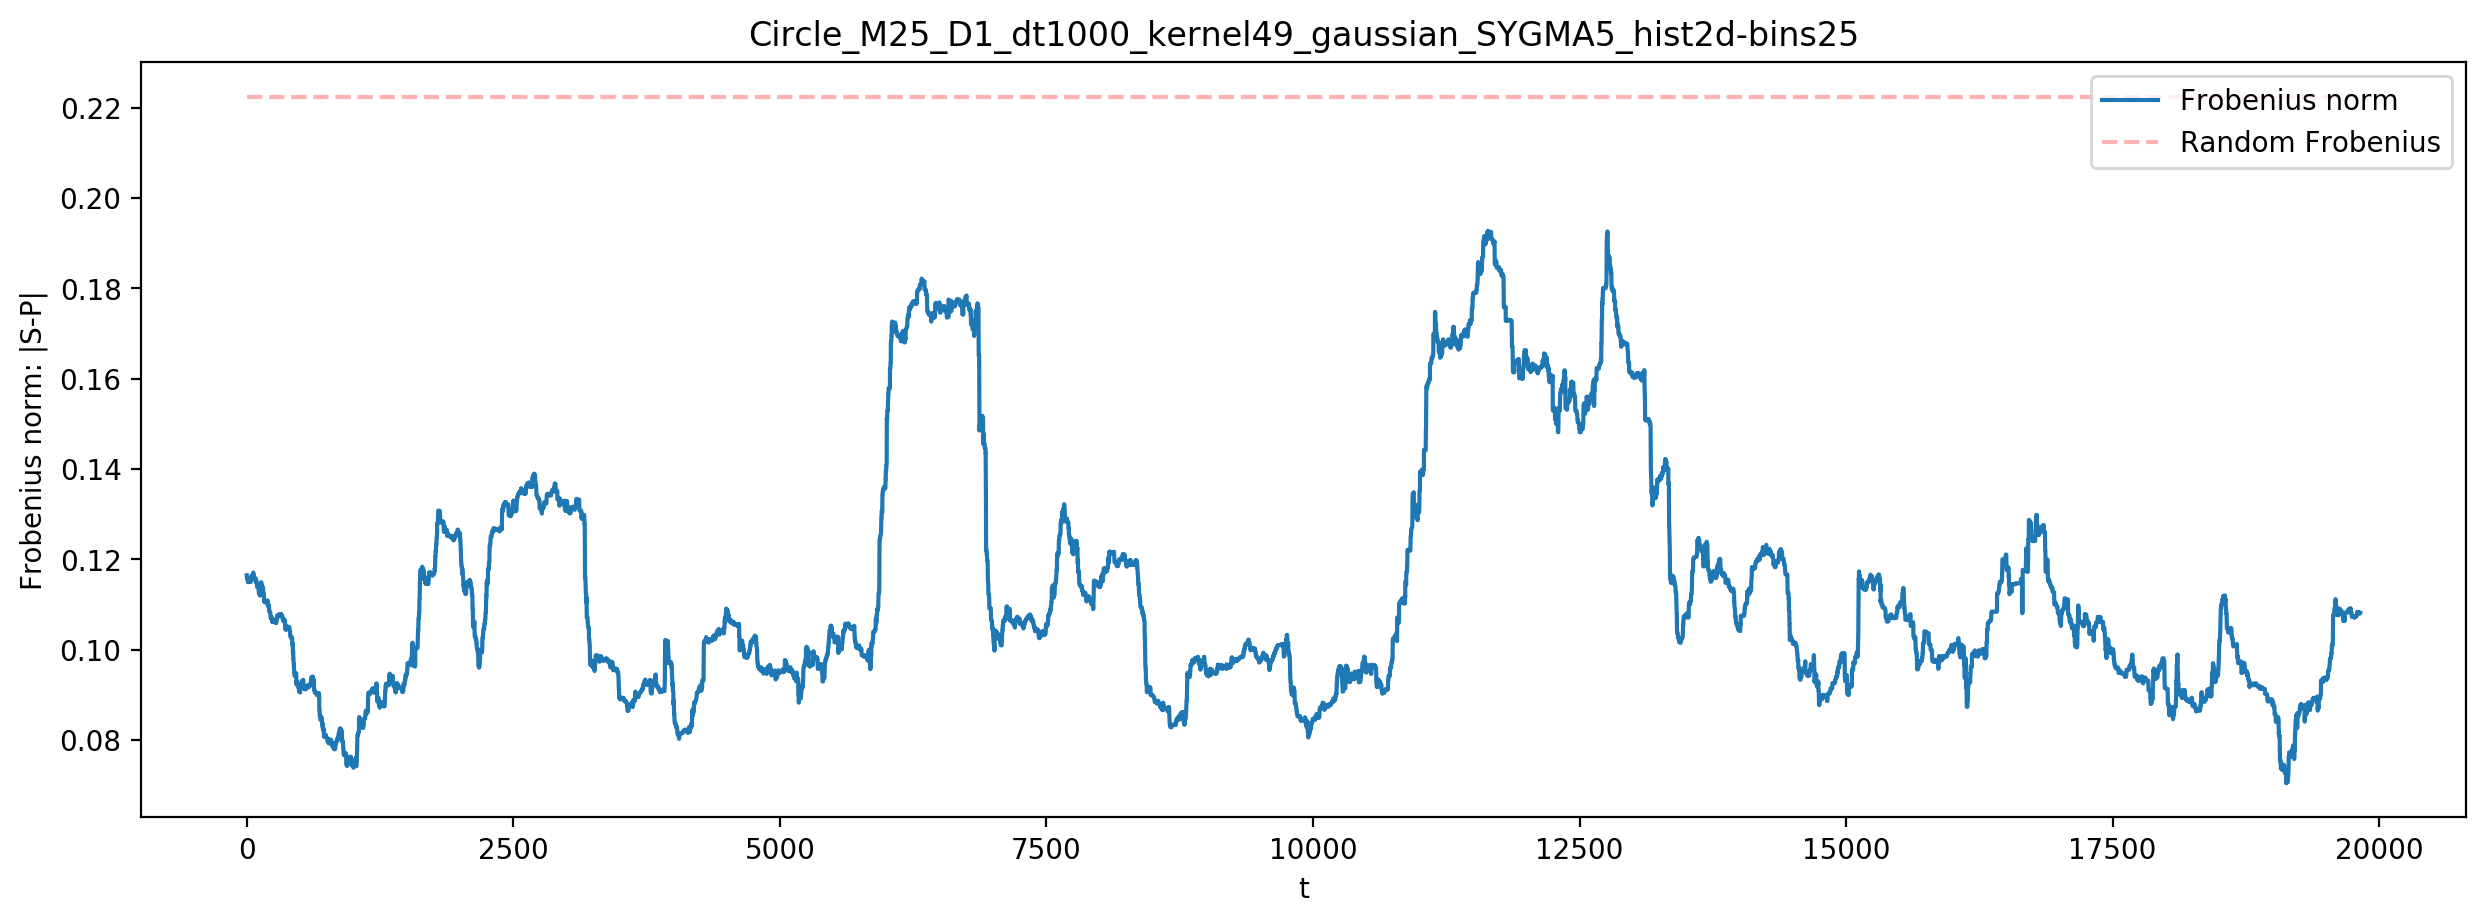

In [212]:
plt.figure(figsize=(15,5),dpi=200)
plt.plot(metrics['fro'], label='Frobenius norm')
plt.hlines(np.max(metrics['fro_random']), 0, len(metrics['fro']), label='Random Frobenius', alpha=0.3, color='red', linestyle='--')
plt.title(corr_dir.split('corrmaps')[1][1:] + f'_hist2d-bins{bins}') 
plt.xlabel('t')
plt.ylabel('Frobenius norm: |S-P|')
plt.legend()
plt.show()

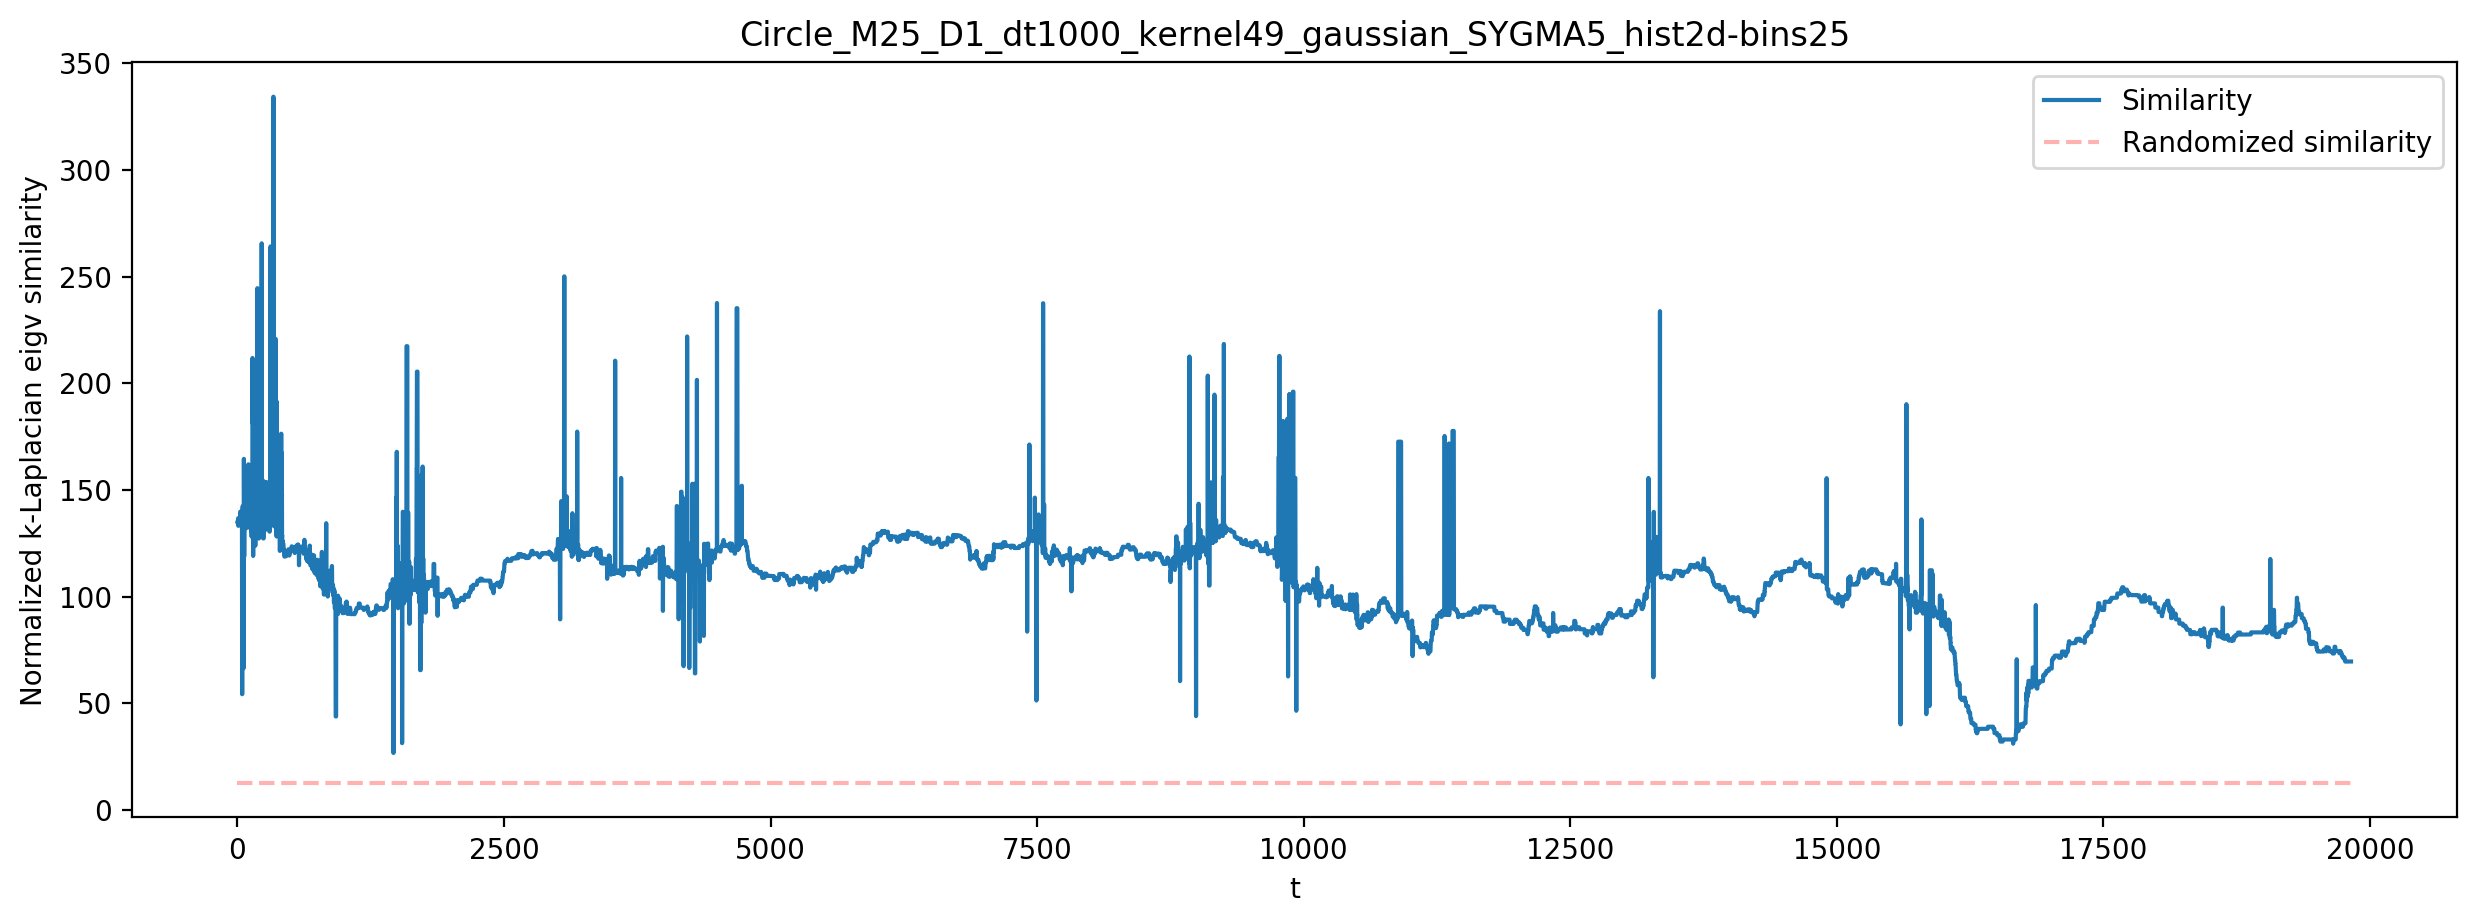

In [211]:
plt.figure(figsize=(15,5),dpi=200)
plt.plot(metrics['lap_values'], label='Similarity')
plt.hlines(np.min(metrics['lap_values_random']), 0, len(metrics['lap_values']), label='Randomized similarity', alpha=0.3, color='red', linestyle='--')
plt.title(corr_dir.split('corrmaps')[1][1:] + f'_hist2d-bins{bins}') #  + '_SELECTED-VLAD'
# plt.plot(rears_indicators_abs, color='green', alpha=0.3)
# plt.plot(speed_, alpha=0.3)
plt.xlabel('t')
plt.ylabel('Normalized k-Laplacian eigv similarity')
plt.legend()
plt.show()

In [176]:
# metrics_name =f'./experimental_data/SP_experiments/' + corr_dir.split('corrmaps')[1][1:] + f'_hist2d-bins{bins}'
# np.save(metrics_name, metrics) 

 - what is the origin of periodicity?
 - need some strong argument how 'order' neurons by their place specificity, std is too simple?

# Stable component

In [374]:
name = 'TOY' if TOY_DATASET else f'Circle_M{mouse}_D{day}'

if kernel_type == 'exponential':
    corr_dir_ext = f'./experimental_data/corrmap_data_ext/corrmaps_' + name +  f'_dt{dt}_kernel{kernel_size}_{kernel_type}_TRISE{T_RISE}_TOFF{T_OFF}'  + \
            (f'_selected_A{ACTIVITY_SELECTIVE_THRESHOLD}_S{STD_SELECTIVE_THRESHOLD}' if SELECT_NEURONS else '')
    
elif kernel_type == 'gaussian':
    corr_dir_ext = f'./experimental_data/corrmap_data_ext/corrmaps_' + name + f'_dt{dt}_kernel{kernel_size}_{kernel_type}_SYGMA{SYGMA}'  + \
            (f'_selected_A{ACTIVITY_SELECTIVE_THRESHOLD}_S{STD_SELECTIVE_THRESHOLD}' if SELECT_NEURONS else '')

if os.path.exists(corr_dir_ext):
        if REMAKE_CORR:
            print('Removing corr_dir?')
            answer = input()
            if answer == 'yes':
                shutil.rmtree(corr_dir_ext)
                os.makedirs(corr_dir_ext, exist_ok=True)
else:
    os.makedirs(corr_dir_ext)
    
    
pf_dir_ext = f'./experimental_data/pf_data_ext/pf_' + name + f'_dt{dt}_hist2d-bins{bins}' + \
            (f'_selected_A{ACTIVITY_SELECTIVE_THRESHOLD}_S{STD_SELECTIVE_THRESHOLD}' if SELECT_NEURONS else '')

if os.path.exists(pf_dir_ext):
        if REMAKE_PF:
            print('Removing pf_dir?')
            answer = input()
            if answer == 'yes':
                shutil.rmtree(pf_dir_ext)
                os.makedirs(pf_dir_ext, exist_ok=True)
else:
    os.makedirs(pf_dir_ext)

Removing corr_dir?
yes
Removing pf_dir?
yes


In [379]:
if REMAKE_CORR:
    _ = Parallel(n_jobs=10, verbose=0)(delayed(calc_spike_similarity_cuda)(sp_torch_batch,
                                                                             spdata_torch[neurons_selected,:i+dt], 
                                                                             save=True,
                                                                             corr_dir=corr_dir_ext,
                                                                             i=i) for i in tqdm_notebook(range(start,end)))
    clear_output()

In [ ]:
# # is there will be spurious correlations in PF?
# if REMAKE_PF:
#     pf_paths = Parallel(n_jobs=-1, verbose=1)(delayed(place_field_correlation)(spdata_bool[neurons_selected,:i+dt], 
#                                                                               coords_[:i+dt,:],
#                                                                               save=True,
#                                                                               pf_dir=pf_dir_ext,
#                                                                               i=i,
#                                                                               bins=bins) for i in tqdm_notebook(range(start,end)))
#     clear_output()

In [382]:
corr_ext_paths = np.array([os.path.join(corr_dir_ext, path) for path in sorted(os.listdir(corr_dir_ext), key=lambda x: int(x.split('.')[0]))])

In [384]:
A_s_ext = Parallel(n_jobs=-1)(delayed(np.load)(p) for p in tqdm_notebook(corr_ext_paths))
A_s_ext = np.stack(A_s_ext, 0).reshape((len(corr_ext_paths),-1))
# edge_threshold = 0.2
# A_s[A_s < threshold] = 0
# A_s = sparse.csr_matrix(A_s)
A_s_ext = A_s_ext[:,A_s_ext.sum(0) > 0]

In [385]:
graph_variance_kernel_size=dt

def graphs_variance(A_s):
    A_s_mean = A_s.mean(0)
    D = np.linalg.norm(A_s - A_s_mean, axis=-1)
    return D.mean()

In [386]:
# # metric = lambda p1,p2: laplacian_keigv_similarity(p1, p2, neurons_selected=neurons_selected, return_nonsingle=False, normalize=True, k=10)
# D_s = Parallel(n_jobs=2, backend='multiprocessing')(delayed(graphs_variance)(A_s[i:i+graph_variance_kernel_size]) \
#                                                   for i in tqdm_notebook(range(len(A_s) - graph_variance_kernel_size)))

In [387]:
D_s = []
for i in tqdm_notebook(range(0, len(A_s_ext) - graph_variance_kernel_size, 20)):
    D_s.append(graphs_variance(A_s_ext[i:i+graph_variance_kernel_size]))

### Make random connectivities

In [450]:
X_random = np.random.randn(N,T)
A_s_random = []

for i in tqdm_notebook(range(T-dt)):
    X_random_dt = X_random[:,:i+dt] - X_random[:,:i+dt].mean(1)[:,None]
    S = X_random_dt@X_random_dt.T
    X_random_norms = np.linalg.norm(X_random_dt, axis=1)[:,None]
    S = S / (X_random_norms@X_random_norms.T + 1e-10)
    S[np.diag_indices_from(S)] = 0
    A_s_random.append(S)
    
A_s_random = np.stack(A_s_random)

In [451]:
D_s_random = []
for i in tqdm_notebook(range(0, len(A_s_random) - graph_variance_kernel_size, 20)):
    D_s_random.append(graphs_variance(A_s_random[i:i+graph_variance_kernel_size]))

In [452]:
def sim_connectivity(N):
    C = np.random.uniform(size=(N,N))
    C = C.T@C
    C[np.diag_indices_from(C)] = 0
    return C/C.max()

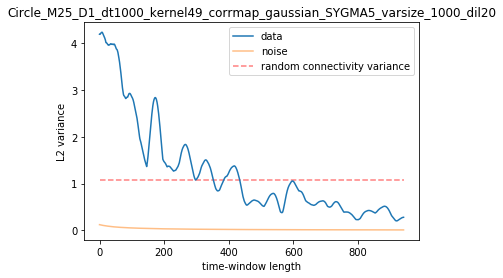

In [453]:
var_random = graphs_variance(np.concatenate([sim_connectivity(N) for _ in range(graph_variance_kernel_size)]))
# D_s_ = MinMaxScaler().fit_transform(np.array(D_s)[:,None])
plt.plot(D_s, label='data')
plt.xlabel('time-window length')
plt.ylabel('L2 variance')
plt.title('Circle_M25_D1_dt1000_kernel49_corrmap_gaussian_SYGMA5' + f'_varsize_{graph_variance_kernel_size}_dil20')
param = speed_[:len(A_s) - graph_variance_kernel_size:20]
param_convolved = np.convolve(param,np.blackman(50),mode='same')
param_convolved_ = MinMaxScaler().fit_transform(param_convolved[:,None])
# plt.plot(param_convolved_, label='speed', alpha=0.5)
plt.plot(D_s_random, label='noise', alpha=0.5)

plt.hlines(y=var_random, xmin=0, xmax=len(D_s), linestyle='--', color='r', alpha=0.5, label='random connectivity variance')

plt.legend()
plt.show()

# Regression

In [91]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import make_scorer
from lightgbm import LGBMRegressor

In [92]:
def MAPE(y, y_pred):
    return (np.linalg.norm(y - y_pred, ord=1, axis=1) / np.linalg.norm(y, ord=1, axis=1)).mean()

def cross_validate(est_mo, X,y,mape_scorer):
    cv_res = cross_val_score(est_mo, X, y, cv=5, scoring=mape_scorer, n_jobs=1)
    return [-cv_res.mean(), cv_res.std()]

In [93]:
dt = 5000

In [94]:
spdata_convolved_.shape, coords_normalized.shape

((522, 17175), (17175, 2))

In [122]:
est = Ridge(random_state=42)
est_mo = MultiOutputRegressor(est)
mape_scorer = make_scorer(MAPE, greater_is_better=False)

iterator = range(0,T-dt,20)
mape_dt = Parallel(n_jobs=10, verbose=0)(delayed(cross_validate)(est_mo, 
                                                               cadata.T[i:i+dt,:], 
                                                               coords_normalized[i:i+dt,:],
                                                               mape_scorer) for i in tqdm_notebook(iterator))
    
mape_dt = np.array(mape_dt)

In [123]:
# est_mo.fit(cadata_.T, coords_)
# coords_pred_ = est_mo.predict(cadata_.T)
# mae_pred = np.linalg.norm(coords_normalized - coords_pred_, ord=1, axis=1) / np.linalg.norm(coords_normalized, ord=1, axis=1)
# plt.hist(mae_pred, bins=50)
# plt.show()

In [124]:
# high_mae_mask = mae_pred > 0.45

In [125]:
# plt.scatter(coords_normalized[:,0], coords_normalized[:,1], alpha=0.1)
# plt.scatter(coords_normalized[:,0][high_mae_mask], coords_normalized[:,1][high_mae_mask], c='r')
# plt.xlabel('x')
# plt.ylabel('y')
# plt.title('M22, D1, Regression MAPE above 0.6')
# plt.show()

In [126]:
# plt.figure(figsize=(15,5), dpi=200)
# plt.plot(np.arange(T)[norm_mask],coords_[:,1])
# plt.scatter(np.arange(T)[norm_mask][high_mae_mask], coords_[:,1][high_mae_mask], alpha=0.5, color='r')
# plt.show()

In [127]:
# plt.figure(figsize=(15,5), dpi=200) 
# plt.plot(np.arange(T),coords_[:,0])
# plt.scatter(np.arange(T)[high_mae_mask], coords_[:,0][high_mae_mask], alpha=0.5, color='r')
# plt.show()

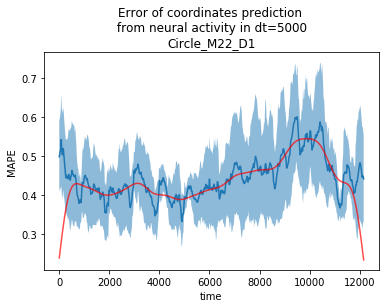

In [128]:
plt.fill_between(x=iterator,
                 y1=mape_dt[:,0] - mape_dt[:,1],
                 y2=mape_dt[:,0] + mape_dt[:,1], 
                 alpha=0.5)
plt.plot(iterator,mape_dt[:,0])
kernel = np.blackman(100) / np.blackman(100).sum()
mape_dt_conv = np.convolve(mape_dt[:,0], kernel, mode='same')
plt.plot(iterator, mape_dt_conv, color='r', alpha=0.7)
# plt.plot(iterator[1000:], phi_[:T-dt:10][1000:], color='orange', label='phi')
plt.title(f'Error of coordinates prediction \n from neural activity in dt={dt} \n' + f'{track}_M{mouse}_D{day}') # name
plt.xlabel('time') 
plt.ylabel('MAPE')
plt.show()

In [562]:
# iterator = range(0,T-dt,10)
# mape_dt_spdata = Parallel(n_jobs=-1, verbose=0)(delayed(cross_validate)(est_mo, 
#                                                                        spdata_convolved_[:,i:i+dt].T, 
#                                                                        coords_[i:i+dt,:],
#                                                                        mape_scorer) for i in tqdm_notebook(iterator))
    
# mape_dt_spdata = np.array(mape_dt_spdata)

In [563]:
# plt.fill_between(x=iterator,
#                  y1=mape_dt_spdata[:,0] - mape_dt_spdata[:,1],
#                  y2=mape_dt_spdata[:,0] + mape_dt_spdata[:,1], 
#                  alpha=0.5)
# plt.plot(iterator,mape_dt_spdata[:,0])
# kernel = np.blackman(100) / np.blackman(100).sum()
# mape_dt_spdata_conv = np.convolve(mape_dt_spdata[:,0], kernel, mode='same')
# plt.plot(iterator, mape_dt_spdata_conv, color='r', alpha=0.7)
# # plt.plot(iterator[1000:], phi_[:T-dt:10][1000:], color='orange', label='phi')
# plt.title(f'Error of coordinates prediction \n from spdata conv in dt={dt} \n' + name)
# plt.xlabel('time') 
# plt.ylabel('MAPE')
# plt.show()